# 基于YOLOv3模型实现摔倒检测

**教程目的**： 通过PaddleDetection API熟悉经典的目标检测框架，为下一步自己手写实现目标检测网络打基础

**教程内容**： 以PaddleDetection API中的特色模型为例，介绍网络结构，以及如何使用此框架训练自己的数据集

**数据准备**： 本教程基于易华录开发者社区的人体摔倒姿态检测数据实现了摔倒检测模型的训练。

**PaddelDetection**： 为方便读者体验，存放在PaddleDetection。

**其他说明**： 本教程所有命令均在Notebook中执行。

<br/>

<font size=5>**学习资源**</font>

<br/>

* 更多的深度学习资料，比如深度学习知识，论文解读，实践案例等，请参考：[awesome-DeepLearning](https://github.com/paddlepaddle/awesome-DeepLearning)
* 更多飞桨框架相关资料，请参考：[飞桨深度学习平台](https://www.paddlepaddle.org.cn/?fr=paddleEdu_aistudio)


## 本次项目实验步骤以及实验结果
**本次实验通过使用PaddleDetection2.0中的YOLOv3(主干网络为mobilenetv3的轻量化模型)，通过几行代码就能实现跌倒的目标检测，后期可部署用于监控医院、疗养院甚至家里等。**

![](https://ai-studio-static-online.cdn.bcebos.com/3e7c7b7dea8c456ba1211938dbd338e1c153ae0ee0284f43ac5c97098538aac8)

按以下几个步骤来介绍项目实现流程。

1. 解压自定义的数据集；

2. 下载安装PaddleDetection包；

2. 自定义数据集划分；

4. 选择模型（本次选择YOLO-v3）进行训练：训练的配置文件说明；

5. 效果可视化：使用训练好的模型进行预测，同时对结果进行可视化；

6. 模型评估和预测：评估模型效果；

7. 预测结果

8. PaddleDetection 预测部署


**检测效果如下图所示：**
![](https://ai-studio-static-online.cdn.bcebos.com/e1e1cce17e20414594b0a63be00045f156785e3f946f43479c4c693a8594cffb)



## 数据和环境准备

### 数据解压
将把完成好标注的跌倒图片（VOC格式数据集）进行解压。

In [ ]:
!unzip -oq /home/aistudio/data/data115779/fall.zip -d /home/aistudio/work/

### 准备环境
目前代码的版本是release/2.0，需要使用PaddlePaddle2.0.2版本。

In [ ]:
! git clone https://gitee.com/paddlepaddle/PaddleDetection.git

安装PaddleDetection依赖库：

In [17]:
%cd /home/aistudio/PaddleDetection/
!pip install -r requirements.txt

### 自定义数据集的划分
本案例原始数据存在标注错误的情况，如标注数据中图像长宽为0，本案例将这部分数据剔除掉，不参与训练和测试。

将数据集按照9：1的比例进行划分，并生成train.txt和val.txt进行训练

In [ ]:
import random
import os
import xml.etree.ElementTree as ET

#生成train.txt和val.txt
random.seed(2020)
data_root_dir = '/home/aistudio/work/fall'

path_list = list()
labels = []#['down','person']#设置你想检测的类别

print("数据总数：",len(os.listdir(data_root_dir))/2)

for img in os.listdir(data_root_dir):
    if not img.endswith(".jpg"):
        continue

    img_path = os.path.join(data_root_dir,img)
    xml_path = os.path.join(data_root_dir,img.replace('jpg', 'xml'))

    # 读取xml获取标签
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # 有些数据标注有问题，如图像大小为空0，过滤掉
    size=root.find('size')
    width = float(size.find('width').text)
    height = float(size.find('height').text)
    if width==0 or height==0:
        continue
    
    for obj in root.iter('object'):
        difficult = int(obj.find('difficult').text)
        cls_name = obj.find('name').text.strip().lower()
        if cls_name not in labels:
            labels.append(cls_name) 

    path_list.append((img_path, xml_path))

print("有效数据个数：",len(path_list))
random.shuffle(path_list)
ratio = 0.9
train_f = open('/home/aistudio/work/train.txt','w') #生成训练文件
val_f = open('/home/aistudio/work/val.txt' ,'w')#生成验证文件

for i ,content in enumerate(path_list):
    img, xml = content
    text = img + ' ' + xml + '\n'

    if i < len(path_list) * ratio:
        train_f.write(text)
    else:
        val_f.write(text)

train_f.close()
val_f.close()

#生成标签文档

print(labels)

with open('/home/aistudio/work/label_list.txt', 'w') as f:
    for text in labels:
        f.write(text+'\n')

数据总数： 7782.0
有效数据个数： 7713
['down', 'person', '10+', 'dog']


## 模型训练

用户在选择好模型后，只需要改动对应的配置文件后，只需要运行train.py文件，即可实现训练。


本项目中，使用YOLOv3模型里的yolov3_mobilenet_v3_large_ssld_270e_voc.yml进行训练

### 配置文件示例
我们使用`configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml`配置进行训练。
在PaddleDetection2.0中，模块化做的更好，可以可自由修改覆盖各模块配置，进行自由组合。

![](https://ai-studio-static-online.cdn.bcebos.com/804d1955ca364af29785a083829fcc48bb3c2ffd57ee461188283bd4fda77d55)



<br><center>配置文件结构说明</center></br>

### 配置文件详细说明

从上图看到`yolov3_mobilenet_v3_large_ssld_270e_voc.yml`配置需要依赖其他的配置文件。在该例子中需要依赖：

![](https://ai-studio-static-online.cdn.bcebos.com/ff1d98d15441421c9601571405aabc31b7aa8245ee14461e9ef2da1b7f9cc779)

在修改文件之前，先给大家解释一下各依赖文件的作用：


```bash
  '_base_/optimizer_270e.yml',主要说明了学习率和优化器的配置，以及设置epochs。在其他的训练的配置中，学习率和优化器是放在了一个新的配置文件中。

  '../datasets/voc.yml'主要说明了训练数据和验证数据的路径，包括数据格式(coco、voc等)

  '_base_/yolov3_reader.yml', 主要说明了读取后的预处理操作，比如resize、数据增强等等

  '_base_/yolov3_mobilenet_v3_large.yml',主要说明模型、和主干网络的情况说明。

  '../runtime.yml',主要说明了公共的运行状态，比如说是否使用GPU、迭代轮数等等
```

数据配置如下：

configs/datasets/voc.yml

**../datasets/voc.yml**

```
metric: VOC
map_type: 11point
num_classes: 4

TrainDataset:
  !VOCDataSet
    dataset_dir: /home/aistudio/work
    anno_path: train.txt
    label_list: label_list.txt
    data_fields: ['image', 'gt_bbox', 'gt_class', 'difficult']

EvalDataset:
  !VOCDataSet
    dataset_dir: /home/aistudio/work
    anno_path: val.txt
    label_list: label_list.txt
    data_fields: ['image', 'gt_bbox', 'gt_class', 'difficult']

TestDataset:
  !ImageFolder
    anno_path: /home/aistudio/work/label_list.txt
```

* num_classes为目标类别数目；
* dataset_dir为数据存放目录；
* anno_path为标注文件相对路径；
* label_list为标签列表。

**_base_/optimizer_270e.yml**

![](https://ai-studio-static-online.cdn.bcebos.com/fde223d65de64433b7c560938d00eafc41d7bfe03053424ab7d1bdffb631f4b4)

* epoch为训练的轮数；
* base_lr为初始学习率。

<br><center>配置文件结构说明</center></br>

### 执行训练
执行下面命令开始进行训练，需要指定训练配置文件路径`-c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml`，`--eval`参数指定在训练过程中进行评估。

In [ ]:
%cd /home/aistudio/PaddleDetection
!python tools/train.py -c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml --eval 

## 模型评估
需要指定评估配置文件路径`-c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml`，被评估的模型路径`-o weights=output/yolov3_mobilenet_v3_large_ssld_270e_voc/best_model.pdparams`。

In [ ]:
%cd /home/aistudio/PaddleDetection/
!python -u tools/eval.py -c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml  \
-o weights=/home/aistudio/work/best_model.pdparams

## 模型预测
在执行`tools/infer.py`后，在output文件夹下会生成对应的预测结果。

需要指定:
* 预测配置文件`-c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml`;
* 预测用到的模型`-o weights=/home/aistudio/work/best_model.pdparams`;
* 预测的图像路径`--infer_img=/home/aistudio/work/people_930.jpg`。

In [14]:
!python tools/infer.py -c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml \
  -o weights=/home/aistudio/work/best_model.pdparams \
  --infer_img=/home/aistudio/work/people_930.jpg

推理结果可视化：

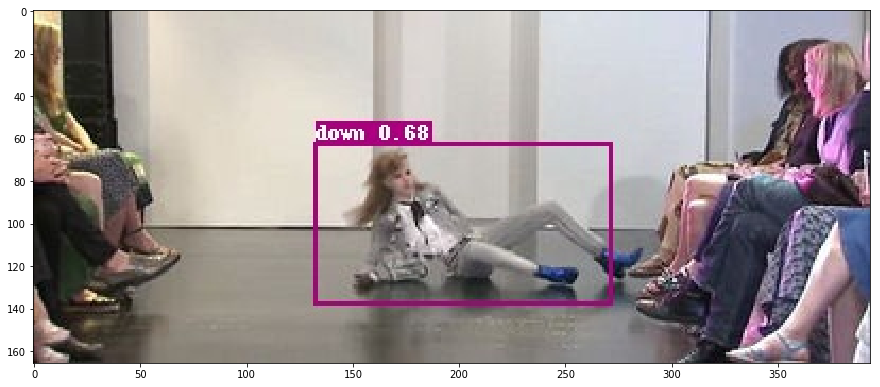

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt 
import cv2

infer_img = cv2.imread("output/people_930.jpg")
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(infer_img, cv2.COLOR_BGR2RGB))
plt.show()

## PaddleDetection 预测部署

PaddleDetection提供了Paddle Inference、Paddle Serving、Paddle-Lite多种部署形式，支持服务端、移动端、嵌入式等多种平台，提供了完善的Python和C++部署方案。

**PaddleDetection支持的部署形式说明**
|形式|语言|教程|设备/平台|
|-|-|-|-|
|Paddle Inference|Python|已完善|Linux(ARM\X86)、Windows
|Paddle Inference|C++|已完善|Linux(ARM\X86)、Windows|
|Paddle Serving|Python|已完善|Linux(ARM\X86)、Windows|
|Paddle-Lite|C++|已完善|Android、IOS、FPGA、RK...


### Paddle Inference部署

#### 导出模型

导出模型，默认存储于PaddleDetection/output_inference目录

In [19]:
%cd /home/aistudio/PaddleDetection
!python tools/export_model.py -c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml \
 -o weights=/home/aistudio/work/best_model.pdparams 

####  使用PaddleInference进行预测
* Python部署 支持`CPU`、`GPU`和`XPU`环境，支持，windows、linux系统，支持NV Jetson嵌入式设备上部署。参考文档[python部署](python/README.md)
* C++部署 支持`CPU`、`GPU`和`XPU`环境，支持，windows、linux系统，支持NV Jetson嵌入式设备上部署。参考文档[C++部署](cpp/README.md)
* PaddleDetection支持TensorRT加速,相关文档请参考[TensorRT预测部署教程](TENSOR_RT.md)

**注意:**  Paddle预测库版本需要>=2.1，batch_size>1仅支持YOLOv3和PP-YOLO。


In [20]:
!python deploy/python/infer.py --model_dir=output_inference/yolov3_mobilenet_v3_large_ssld_270e_voc \
 --image_file=/home/aistudio/work/people_930.jpg --use_gpu=True

**推理数据**

推理时间：Inference: 30.33137321472168 ms per batch image

检测出目标id，置信度以及预测框的坐标：class_id:0, confidence:0.6939, left_top:[254.97,189.10],right_bottom:[333.20,224.15]

保存路径：save result to: output/fall_39.jpg

### PaddleServing部署
#### 安装 paddle serving
请参考[PaddleServing](https://github.com/PaddlePaddle/Serving/tree/v0.6.0)中安装教程安装（版本>=0.6.0）。

#### 导出模型

如果需要导出`PaddleServing`格式的模型，需要设置`export_serving_model=True`:
```buildoutcfg
python tools/export_model.py -c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml -o weights=output/yolov3_mobilenet_v3_large_ssld_270e_voc/best_model.pdparams --export_serving_model=True
```
预测模型会导出到`output_inference/yolov3_mobilenet_v3_large_ssld_270e_voc`目录下，分别为`infer_cfg.yml`, `model.pdiparams`,  `model.pdiparams.info`, `model.pdmodel`, `serving_client/`文件夹, `serving_server/`文件夹。

模型导出具体请参考文档[PaddleDetection模型导出教程](EXPORT_MODEL.md)。

In [21]:
# 安装paddle_serving_client
!pip install paddle_serving_client

In [22]:
!python tools/export_model.py -c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml \
-o weights=/home/aistudio/work/best_model.pdparams  \
--export_serving_model=True

#### 使用PaddleServing进行预测
* [安装PaddleServing](https://github.com/PaddlePaddle/Serving/blob/develop/README.md#installation)
* [使用PaddleServing](./serving/README.md)


### PaddleLite部署
- [使用PaddleLite部署PaddleDetection模型](./lite/README.md)
- 详细案例请参考[Paddle-Lite-Demo](https://github.com/PaddlePaddle/Paddle-Lite-Demo)部署。更多内容，请参考[Paddle-Lite](https://github.com/PaddlePaddle/Paddle-Lite)

### Benchmark测试

PP-YOLO模型benchmark测试为不包含数据预处理和网络输出后处理(NMS)的网络结构部分数据，导出模型时须指定--exlcude_nms来裁剪掉模型中后处理的NMS部分，通过如下命令进行模型导出和benchmark测试。
```
# 导出模型，通过--exclude_nms参数裁剪掉模型中的NMS部分，默认存储于output_inference/yolov3_mobilenet_v3_large_ssld_270e_voc目录
python tools/export_model.py -c -c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml -o weights=output/yolov3_mobilenet_v3_large_ssld_270e_voc/best_model.pdparams --exclude_nms

# FP32 benchmark测试
CUDA_VISIBLE_DEVICES=0 python deploy/python/infer.py --model_dir=output_inference/yolov3_mobilenet_v3_large_ssld_270e_voc --image_file=/home/aistudio/work/fall3.jpg --use_gpu=True --run_benchmark=True --run_mode=trt_fp32

# TensorRT FP16 benchmark测试
CUDA_VISIBLE_DEVICES=0 python deploy/python/infer.py --model_dir=output_inference/yolov3_mobilenet_v3_large_ssld_270e_voc --image_file=/home/aistudio/work/fall3.jpg --use_gpu=True --run_benchmark=True --run_mode=trt_fp16
```

In [24]:
!python deploy/python/infer.py --model_dir=output_inference/yolov3_mobilenet_v3_large_ssld_270e_voc --image_file=/home/aistudio/work/people_930.jpg \
--use_gpu=True --run_benchmark=True

# 总结

由上图我们可以看到，使用PaddleDetection完成了跌倒的目标识别检测，并且mAP已经达到了**80.28%**。

**优化方案**

可以通过增加数据集、选择更优化模型，增加训练的次数。

**后期应用**

后期可以部署到医院、疗养院等公共场合，甚至家里的监控中实现跌倒目标检测，可以及时救援，以免造成更大的损失。

# 更多深度学习资源
## 一站式深度学习平台[awesome-DeepLearning](https://github.com/paddlepaddle/awesome-DeepLearning)

* **深度学习入门课**

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/3373732039aa4a818dd8b1faefaa44a6b31497348c29446ca28dd218234814d1' width='700'></center>

* **深度学习百问**

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/433d373002734631a1da0273b2fa9dfbb45279e97075429ca0530c5fa787b6d3' width='700'></center>

* **特色课**

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/2b99d97c34ea4d168ce5a8e33fce28ef6c95fee5418f455cad15557952e8b0b2' width='700'></center>

* **产业实践**

<center><img src='https://ai-studio-static-online.cdn.bcebos.com/8a6ae927f7394737b6b2f13bf2d120c9970092ce59d44faa9ade500aa515ea19' width='700'></center>

   PaddleEdu使用过程中有任何问题欢迎在[awesome-DeepLearning](https://github.com/paddlepaddle/awesome-DeepLearning)提issue，同时更多深度学习资料请参阅[飞桨深度学习平台](https://www.paddlepaddle.org.cn/?fr=paddleEdu_aistudio)。
   
## 飞桨技术交流群（QQ）

目前QQ群已有2000+同学一起学习，欢迎扫码加入
<center><img src='https://ai-studio-static-online.cdn.bcebos.com/17dd8cc4b14e40d091812d03780580672fe6ea6bb77e4f77889451cf1dcdc5ad' ></center>